In [32]:
###########################
#Case Study: Telecom Churn
#Author: Ambrish Gupta
#Date:June 08,2018
##########################    
    
####### import packages 
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#os.chdir("C:/PGDMLAI/Course 3 - Machine Learning/Telecom Churn - ML Group Case Study")




In [2]:
### read the csv file
telecom_churn = pd.read_csv('telecom_churn_data.csv')
telecom_churn.info()
telecom_churn.shape
telecom_churn.head()
telecom_churn.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,...,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,...,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,7.380000,...,0.000000,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,34.310000,...,0.000000,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,118.740000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,49.000000,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000


In [3]:
#### Data Processing & data Cleaning 

### Renaming the vbc variables ####
telecom_churn['vbc_3g_6']=telecom_churn['jun_vbc_3g']
telecom_churn['vbc_3g_7']=telecom_churn['jul_vbc_3g']
telecom_churn['vbc_3g_8']=telecom_churn['aug_vbc_3g']
telecom_churn['vbc_3g_9']=telecom_churn['sep_vbc_3g']

telecom_churn.drop(['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g','sep_vbc_3g'],axis=1,inplace=True)



###Finding high value accounts
#telecom_churn.drop(['totalrech_avg_goodphase'], axis = 1, inplace = True)
telecom_churn['totalrech_avg_goodphase']=(telecom_churn['total_rech_amt_6']+telecom_churn['total_rech_amt_7'])/2
telecom_churn = telecom_churn[telecom_churn['totalrech_avg_goodphase'] >  telecom_churn.totalrech_avg_goodphase.quantile(0.7)]


###Adding the churn status
telecom_churn['churn_status']= ((telecom_churn.total_ic_mou_9 <=0) & (telecom_churn.total_og_mou_9 <=0)
                                & (telecom_churn.vol_2g_mb_9 <=0) & (telecom_churn.vol_3g_mb_9 <=0)).astype('int')

###91% are non-converters
telecom_churn['churn_status'].value_counts()/telecom_churn['churn_status'].shape[0]

#####removing all month 9 values,date columns and circleId
telecom_churn_sub=telecom_churn[telecom_churn.columns.drop(list(telecom_churn.filter(regex='_9')))]
telecom_churn_sub=telecom_churn_sub[telecom_churn_sub.columns.drop(list(telecom_churn_sub.filter(regex='date')))]
telecom_churn_sub.drop(['circle_id'],axis=1,inplace=True)
telecom_churn_sub.shape
print(telecom_churn_sub.shape)



(29979, 163)


In [4]:

##Replacing NA's with zero values for all the columns
telecom_churn_NAsToZero=telecom_churn_sub.apply(lambda x: x.fillna(0,axis=0))
print(telecom_churn_NAsToZero.shape)


(29979, 163)


In [5]:

####### Removing columns which have only 0 values
telecom_churn_NAsToZero.drop(['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou', 
                        'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',
                        'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','mobile_number','totalrech_avg_goodphase'],axis=1,inplace=True)


print(telecom_churn_NAsToZero.shape)


(29979, 152)


In [6]:
#### Derived Variable
##############
telecom_churn_NAsToZero['arpu_tmp']=(telecom_churn_NAsToZero['arpu_6']+telecom_churn_NAsToZero['arpu_7'])/2
telecom_churn_NAsToZero['onnet_mou_tmp']=(telecom_churn_NAsToZero['onnet_mou_6']+telecom_churn_NAsToZero['onnet_mou_7'])/2
telecom_churn_NAsToZero['offnet_mou_tmp']=(telecom_churn_NAsToZero['offnet_mou_6']+telecom_churn_NAsToZero['offnet_mou_7'])/2
telecom_churn_NAsToZero['loc_og_t2t_mou_tmp']=(telecom_churn_NAsToZero['loc_og_t2t_mou_6']+telecom_churn_NAsToZero['loc_og_t2t_mou_7'])/2
telecom_churn_NAsToZero['loc_og_t2m_mou_tmp']=(telecom_churn_NAsToZero['loc_og_t2m_mou_6']+telecom_churn_NAsToZero['loc_og_t2m_mou_7'])/2
telecom_churn_NAsToZero['loc_og_t2f_mou_tmp']=(telecom_churn_NAsToZero['loc_og_t2f_mou_6']+telecom_churn_NAsToZero['loc_og_t2f_mou_7'])/2
telecom_churn_NAsToZero['loc_og_t2c_mou_tmp']=(telecom_churn_NAsToZero['loc_og_t2c_mou_6']+telecom_churn['loc_og_t2c_mou_7'])/2
telecom_churn_NAsToZero['loc_og_mou_tmp']=(telecom_churn_NAsToZero['loc_og_mou_6']+telecom_churn_NAsToZero['loc_og_mou_7'])/2
telecom_churn_NAsToZero['std_og_t2t_mou_tmp']=(telecom_churn_NAsToZero['std_og_t2t_mou_6']+telecom_churn_NAsToZero['std_og_t2t_mou_7'])/2
telecom_churn_NAsToZero['std_og_t2m_mou_tmp']=(telecom_churn['std_og_t2m_mou_6']+telecom_churn_NAsToZero['std_og_t2m_mou_7'])/2
telecom_churn_NAsToZero['std_og_mou_tmp']=(telecom_churn_NAsToZero['std_og_mou_6']+telecom_churn_NAsToZero['std_og_mou_7'])/2
telecom_churn_NAsToZero['total_og_mou_tmp']=(telecom_churn_NAsToZero['total_og_mou_6']+telecom_churn_NAsToZero['total_og_mou_7'])/2
telecom_churn_NAsToZero['loc_ic_t2t_mou_tmp']=(telecom_churn_NAsToZero['loc_ic_t2t_mou_6']+telecom_churn_NAsToZero['loc_ic_t2t_mou_7'])/2
telecom_churn_NAsToZero['loc_ic_t2m_mou_tmp']=(telecom_churn_NAsToZero['loc_ic_t2m_mou_6']+telecom_churn_NAsToZero['loc_ic_t2m_mou_7'])/2
telecom_churn_NAsToZero['loc_ic_mou_tmp']=(telecom_churn_NAsToZero['loc_ic_mou_6']+telecom_churn_NAsToZero['loc_ic_mou_7'])/2
telecom_churn_NAsToZero['std_ic_t2t_mou_tmp']=(telecom_churn_NAsToZero['std_ic_t2t_mou_6']+telecom_churn_NAsToZero['std_ic_t2t_mou_7'])/2
telecom_churn_NAsToZero['std_ic_t2m_mou_tmp']=(telecom_churn_NAsToZero['std_ic_t2m_mou_6']+telecom_churn_NAsToZero['std_ic_t2m_mou_7'])/2
telecom_churn_NAsToZero['std_ic_mou_tmp']=(telecom_churn_NAsToZero['std_ic_mou_6']+telecom_churn_NAsToZero['std_ic_mou_7'])/2
telecom_churn_NAsToZero['total_ic_mou_tmp']=(telecom_churn_NAsToZero['total_ic_mou_6']+telecom_churn_NAsToZero['total_ic_mou_7'])/2
telecom_churn_NAsToZero['isd_ic_mou_tmp']=(telecom_churn_NAsToZero['isd_ic_mou_6']+telecom_churn_NAsToZero['isd_ic_mou_7'])/2
telecom_churn_NAsToZero['total_rech_num_tmp']=(telecom_churn_NAsToZero['total_rech_num_6']+telecom_churn_NAsToZero['total_rech_num_7'])/2
telecom_churn_NAsToZero['total_rech_amt_tmp']=(telecom_churn_NAsToZero['total_rech_amt_6']+telecom_churn_NAsToZero['total_rech_amt_7'])/2
telecom_churn_NAsToZero['max_rech_amt_tmp']=(telecom_churn_NAsToZero['max_rech_amt_6']+telecom_churn_NAsToZero['max_rech_amt_7'])/2
telecom_churn_NAsToZero['last_day_rch_amt_tmp']=(telecom_churn_NAsToZero['last_day_rch_amt_6']+telecom_churn_NAsToZero['last_day_rch_amt_7'])/2
telecom_churn_NAsToZero['max_rech_data_tmp']=(telecom_churn_NAsToZero['max_rech_data_6']+telecom_churn_NAsToZero['max_rech_data_7'])/2
telecom_churn_NAsToZero['av_rech_amt_data_tmp']=(telecom_churn_NAsToZero['av_rech_amt_data_6']+telecom_churn_NAsToZero['av_rech_amt_data_7'])/2
telecom_churn_NAsToZero['vol_2g_mb_tmp']=(telecom_churn_NAsToZero['vol_2g_mb_6']+telecom_churn_NAsToZero['vol_2g_mb_7'])/2
telecom_churn_NAsToZero['vol_3g_mb_tmp']=(telecom_churn_NAsToZero['vol_3g_mb_6']+telecom_churn_NAsToZero['vol_3g_mb_7'])/2
telecom_churn_NAsToZero['arpu_3g_tmp']=(telecom_churn_NAsToZero['arpu_3g_6']+telecom_churn_NAsToZero['arpu_3g_7'])/2
telecom_churn_NAsToZero['arpu_2g_tmp']=(telecom_churn_NAsToZero['arpu_2g_6']+telecom_churn_NAsToZero['arpu_2g_7'])/2
telecom_churn_NAsToZero['vbc_3g_tmp']=(telecom_churn_NAsToZero['vbc_3g_6']+telecom_churn_NAsToZero['vbc_3g_7'])/2



In [7]:

### Total Roaming  IC & OG  ### 
telecom_churn_NAsToZero['total_roam_ic_mou']  =telecom_churn_NAsToZero['roam_ic_mou_6'] + telecom_churn_NAsToZero['roam_ic_mou_7']+telecom_churn_NAsToZero['roam_ic_mou_8']
telecom_churn_NAsToZero['total_roam_og_mou']=telecom_churn_NAsToZero['roam_og_mou_6'] + telecom_churn_NAsToZero['roam_og_mou_7']+telecom_churn_NAsToZero['roam_og_mou_8']

### Total IC & OG  ### 
telecom_churn_NAsToZero['total_ic_mou']=telecom_churn_NAsToZero['total_ic_mou_6'] + telecom_churn_NAsToZero['total_ic_mou_7']+telecom_churn_NAsToZero['total_ic_mou_8']
telecom_churn_NAsToZero['total_og_mou']=telecom_churn_NAsToZero['total_og_mou_6'] + telecom_churn_NAsToZero['total_og_mou_7']+telecom_churn_NAsToZero['total_og_mou_8']

#### Roaming Percent

#telecom_churn_NAsToZero['total_roam_ic_pct']=telecom_churn_NAsToZero['total_roam_ic_mou']/telecom_churn_NAsToZero['total_ic_mou']
#telecom_churn_NAsToZero['total_roam_og_pct']=telecom_churn_NAsToZero['total_roam_og_mou']/telecom_churn_NAsToZero['total_og_mou']



Var_list=telecom_churn_NAsToZero.columns
print(Var_list.shape)

(187,)


In [8]:
### Creating Flag if the 8 month usage is less than 50% of  average of 6 & 7 month usage

telecom_churn_NAsToZero['arpu_flag']=(telecom_churn_NAsToZero['arpu_8']<telecom_churn_NAsToZero['arpu_tmp']/2).astype('int')
telecom_churn_NAsToZero['onnet_mou_flag']=(telecom_churn_NAsToZero['onnet_mou_8']<telecom_churn_NAsToZero['onnet_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['offnet_mou_flag']=(telecom_churn_NAsToZero['offnet_mou_8']<telecom_churn_NAsToZero['offnet_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_og_t2t_mou_flag']=(telecom_churn_NAsToZero['loc_og_t2t_mou_8']<telecom_churn_NAsToZero['loc_og_t2t_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_og_t2m_mou_flag']=(telecom_churn_NAsToZero['loc_og_t2m_mou_8']<telecom_churn_NAsToZero['loc_og_t2m_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_og_t2f_mou_flag']=(telecom_churn_NAsToZero['loc_og_t2f_mou_8']<telecom_churn_NAsToZero['loc_og_t2f_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_og_t2c_mou_flag']=(telecom_churn_NAsToZero['loc_og_t2c_mou_8']<telecom_churn_NAsToZero['loc_og_t2c_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_og_mou_flag']=(telecom_churn_NAsToZero['loc_og_mou_8']<telecom_churn_NAsToZero['loc_og_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['std_og_t2t_mou_flag']=(telecom_churn_NAsToZero['std_og_t2t_mou_8']<telecom_churn_NAsToZero['std_og_t2t_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['std_og_t2m_mou_flag']=(telecom_churn['std_og_t2m_mou_8']<telecom_churn_NAsToZero['std_og_t2m_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['std_og_mou_flag']=(telecom_churn_NAsToZero['std_og_mou_8']<telecom_churn_NAsToZero['std_og_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['total_og_mou_flag']=(telecom_churn_NAsToZero['total_og_mou_8']<telecom_churn_NAsToZero['total_og_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_ic_t2t_mou_flag']=(telecom_churn_NAsToZero['loc_ic_t2t_mou_8']<telecom_churn_NAsToZero['loc_ic_t2t_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_ic_t2m_mou_flag']=(telecom_churn_NAsToZero['loc_ic_t2m_mou_8']<telecom_churn_NAsToZero['loc_ic_t2m_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['loc_ic_mou_flag']=(telecom_churn_NAsToZero['loc_ic_mou_8']<telecom_churn_NAsToZero['loc_ic_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['std_ic_t2t_mou_flag']=(telecom_churn_NAsToZero['std_ic_t2t_mou_8']<telecom_churn_NAsToZero['std_ic_t2t_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['std_ic_t2m_mou_flag']=(telecom_churn_NAsToZero['std_ic_t2m_mou_8']<telecom_churn_NAsToZero['std_ic_t2m_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['std_ic_mou_flag']=(telecom_churn_NAsToZero['std_ic_mou_8']<telecom_churn_NAsToZero['std_ic_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['total_ic_mou_flag']=(telecom_churn_NAsToZero['total_ic_mou_8']<telecom_churn_NAsToZero['total_ic_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['isd_ic_mou_flag']=(telecom_churn_NAsToZero['isd_ic_mou_8']<telecom_churn_NAsToZero['isd_ic_mou_tmp']/2).astype('int')
telecom_churn_NAsToZero['total_rech_num_flag']=(telecom_churn_NAsToZero['total_rech_num_8']<telecom_churn_NAsToZero['total_rech_num_tmp']/2).astype('int')
telecom_churn_NAsToZero['total_rech_amt_flag']=(telecom_churn_NAsToZero['total_rech_amt_8']<telecom_churn_NAsToZero['total_rech_amt_tmp']/2).astype('int')
telecom_churn_NAsToZero['max_rech_amt_flag']=(telecom_churn_NAsToZero['max_rech_amt_8']<telecom_churn_NAsToZero['max_rech_amt_tmp']/2).astype('int')
telecom_churn_NAsToZero['last_day_rch_amt_flag']=(telecom_churn_NAsToZero['last_day_rch_amt_8']<telecom_churn_NAsToZero['last_day_rch_amt_tmp']/2).astype('int')
telecom_churn_NAsToZero['max_rech_data_flag']=(telecom_churn_NAsToZero['max_rech_data_8']<telecom_churn_NAsToZero['max_rech_data_tmp']/2).astype('int')
telecom_churn_NAsToZero['av_rech_amt_data_flag']=(telecom_churn_NAsToZero['av_rech_amt_data_8']<telecom_churn_NAsToZero['av_rech_amt_data_tmp']/2).astype('int')
telecom_churn_NAsToZero['vol_2g_mb_flag']=(telecom_churn_NAsToZero['vol_2g_mb_8']<telecom_churn_NAsToZero['vol_2g_mb_tmp']/2).astype('int')
telecom_churn_NAsToZero['vol_3g_mb_flag']=(telecom_churn_NAsToZero['vol_3g_mb_8']<telecom_churn_NAsToZero['vol_3g_mb_tmp']/2).astype('int')
telecom_churn_NAsToZero['arpu_3g_flag']=(telecom_churn_NAsToZero['arpu_3g_8']<telecom_churn_NAsToZero['arpu_3g_tmp']/2).astype('int')
telecom_churn_NAsToZero['arpu_2g_flag']=(telecom_churn_NAsToZero['arpu_2g_8']<telecom_churn_NAsToZero['arpu_2g_tmp']/2).astype('int')
telecom_churn_NAsToZero['vbc_3g_flag']=(telecom_churn_NAsToZero['vbc_3g_8']<telecom_churn_NAsToZero['vbc_3g_tmp']/2).astype('int')


In [9]:
##### Data with key variables +  derived variables only
print(telecom_churn_NAsToZero.shape)
New_Var_list=telecom_churn_NAsToZero.columns
print(New_Var_list.shape)
Add_Var=["aon","churn_status"]
Imp_Var_list=list(set(New_Var_list)-set(Var_list)) 

Final_Var_list=Imp_Var_list+Add_Var
print(Final_Var_list)

Modeling_Data=telecom_churn_NAsToZero[Final_Var_list]

Modeling_Data=Modeling_Data.apply(lambda x: x.fillna(0,axis=0))

##### Checking the Mean
Modeling_Data_mean=Modeling_Data.groupby('churn_status')[Modeling_Data.columns].mean()
#Modeling_Data_mean.to_csv("Modeling_Data_mean.csv")



(29979, 218)
(218,)
['std_og_mou_flag', 'vol_3g_mb_flag', 'max_rech_data_flag', 'std_ic_t2t_mou_flag', 'total_rech_amt_flag', 'loc_og_t2f_mou_flag', 'loc_og_t2t_mou_flag', 'vbc_3g_flag', 'loc_og_mou_flag', 'arpu_2g_flag', 'loc_og_t2c_mou_flag', 'loc_ic_t2t_mou_flag', 'max_rech_amt_flag', 'std_ic_mou_flag', 'std_og_t2t_mou_flag', 'arpu_3g_flag', 'total_ic_mou_flag', 'loc_ic_t2m_mou_flag', 'arpu_flag', 'av_rech_amt_data_flag', 'std_ic_t2m_mou_flag', 'onnet_mou_flag', 'vol_2g_mb_flag', 'total_rech_num_flag', 'isd_ic_mou_flag', 'loc_ic_mou_flag', 'last_day_rch_amt_flag', 'loc_og_t2m_mou_flag', 'offnet_mou_flag', 'total_og_mou_flag', 'std_og_t2m_mou_flag', 'aon', 'churn_status']


In [10]:
Modeling_Data.to_csv('C:\\Users\\pboya01\Desktop\\Telecom Churn case study\\Modeling_Data1.csv')

In [47]:

# splitting into X and y
X = Modeling_Data.drop("churn_status", axis = 1)
Y = Modeling_Data.churn_status.astype(int)
Y.value_counts()


###Scaling X valuesModeling_Data
#X_scaled=scale(X)

####Splitting 70-30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

####Recall seems to be the right metric since we are interested in identifying more churners correctly
##Recall <- Number of churners identified/Total number of churners
#####Random Forest/SVM/XG-Boost algorithms should give the best results for prediction.


(20985, 32)
(8994, 32)


In [17]:
#################################################################################

#####################################ADA-BOOST##########################################

#################################################################################

# base estimator
tree = DecisionTreeClassifier(max_depth=10)

# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=.01,
    algorithm="SAMME")

adaboost_model_1.fit(X_train, y_train)
y_pred = adaboost_model_1.predict(X_test)
# metrics
print(metrics.confusion_matrix(y_test, y_pred), "\n")
print("accuracy", metrics.accuracy_score(y_test, y_pred))
print("precision", metrics.precision_score(y_test, y_pred))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred))


[[8026  153]
 [ 477  338]] 

accuracy 0.929953302201
precision 0.688391038697
sensitivity/recall 0.41472392638


In [18]:
# parameter grid
param_grid = {"base_estimator__max_depth" : [3, 10],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
adaboost_model_2 = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.2,
    algorithm="SAMME")

folds = 3
grid_search_adaboost_model_2 = GridSearchCV(adaboost_model_2, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)


grid_search_adaboost_model_2.fit(X_train, y_train)

grid_search_adaboost_model_2.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.7min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.2, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator__max_depth': [3, 10], 'n_estimators': [200, 400, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

## Pavan

In [18]:
print(Modeling_Data.shape)

(29979, 33)


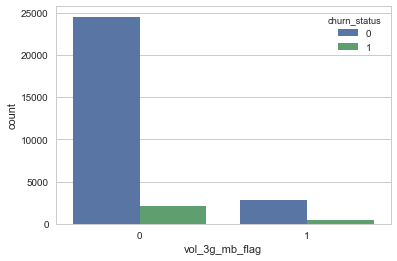

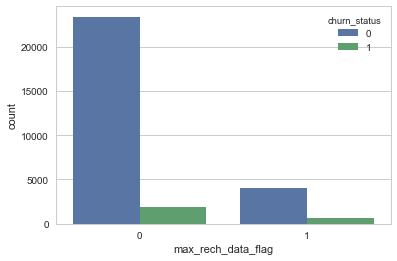

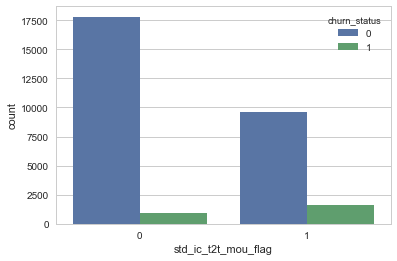

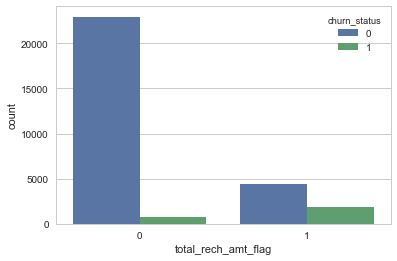

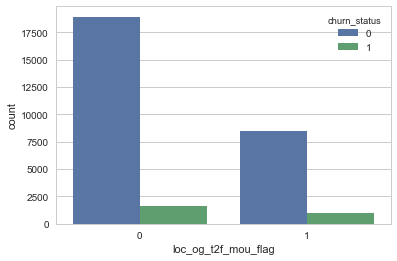

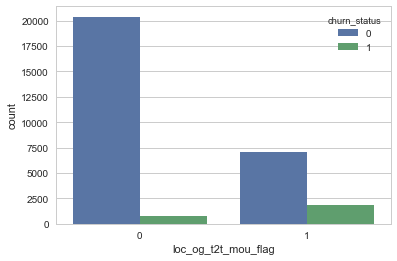

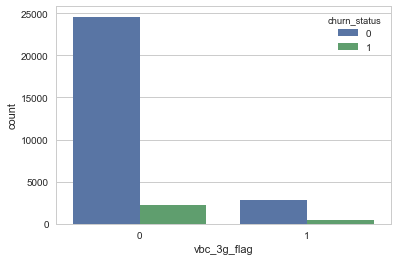

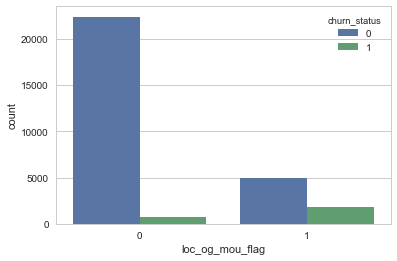

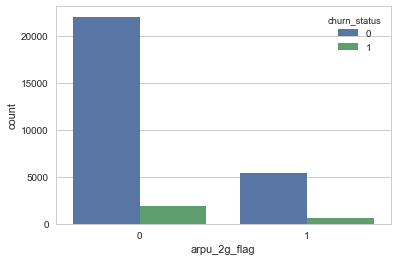

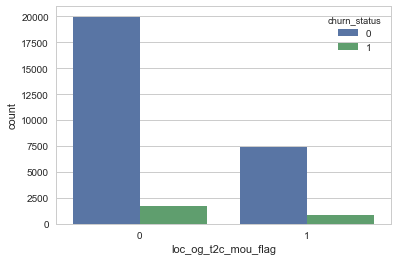

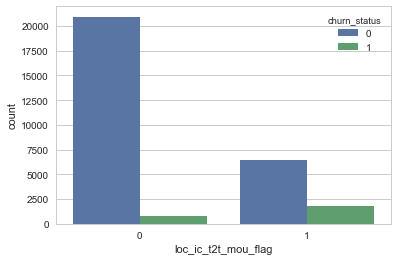

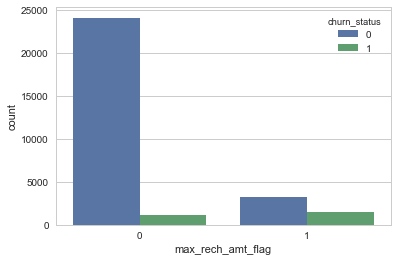

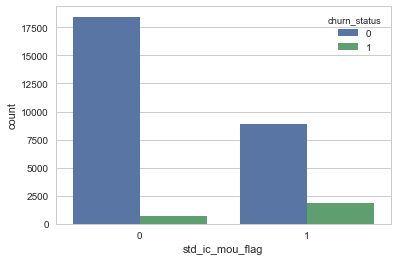

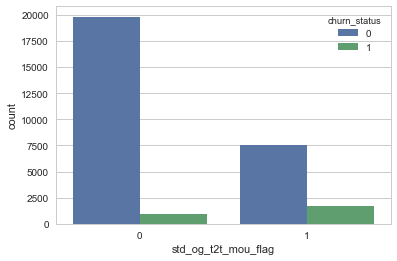

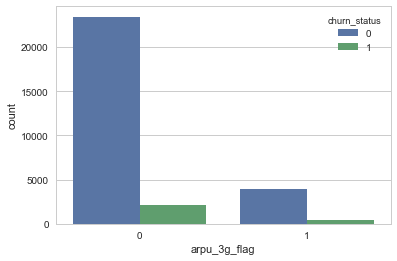

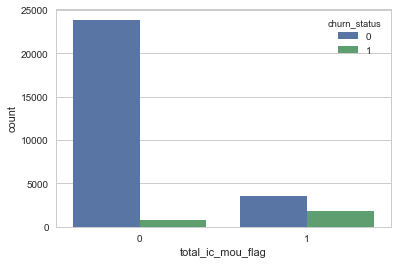

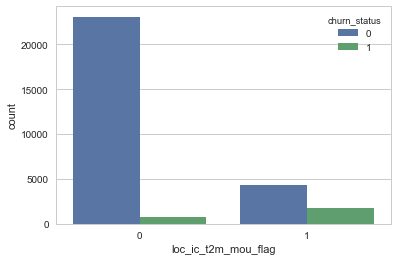

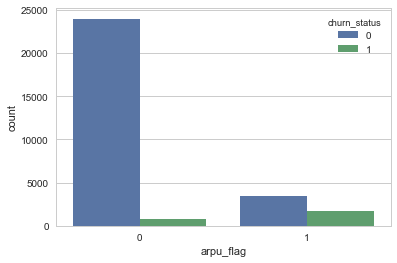

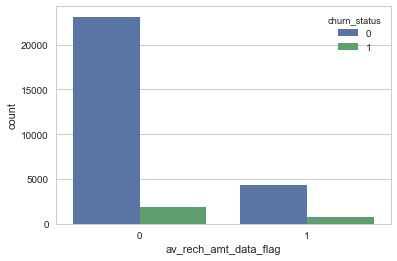

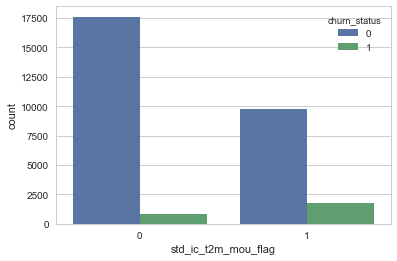

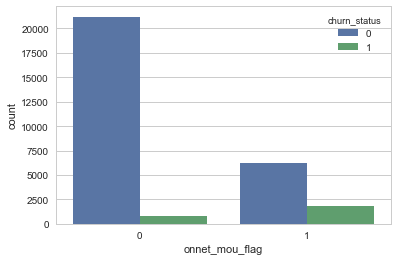

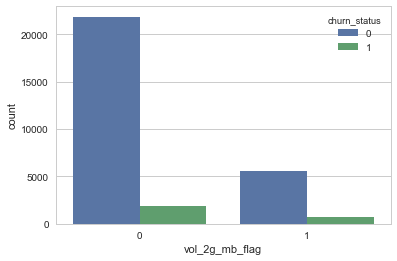

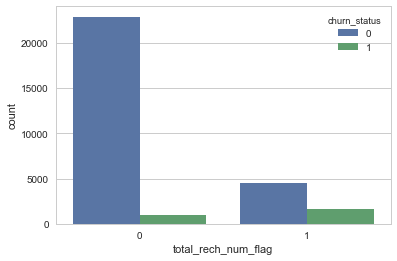

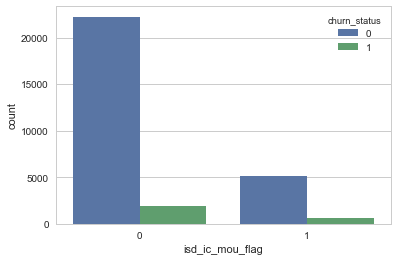

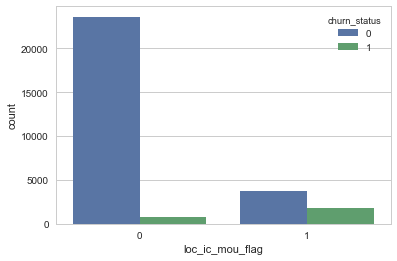

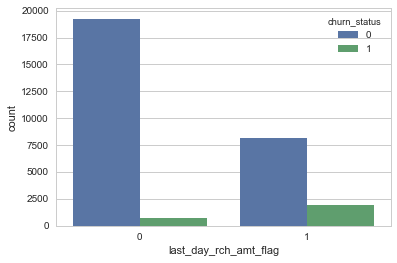

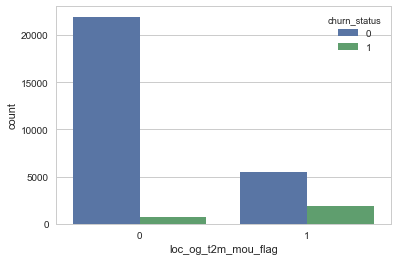

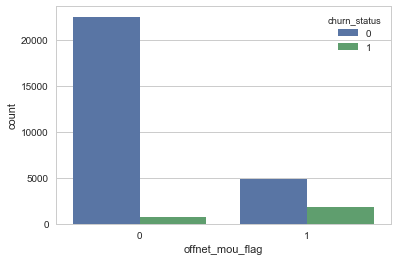

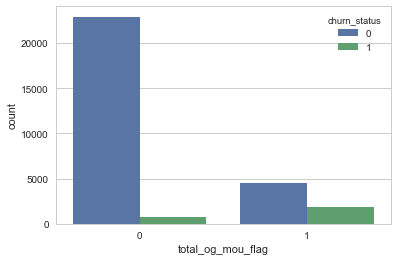

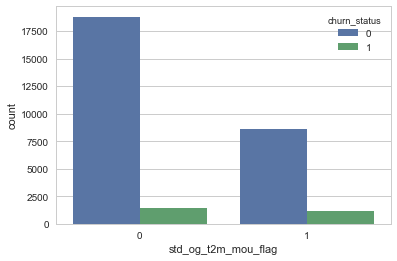

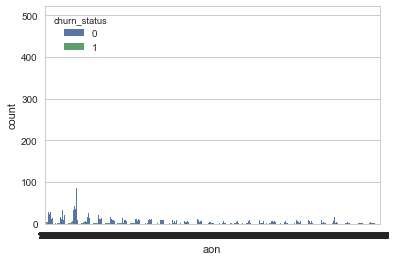

In [19]:
for feature in Modeling_Data.columns[1:32]:
    sns.set(style="whitegrid")
    sns.countplot(x=feature,hue='churn_status',data=Modeling_Data)
    plt.show()

In [33]:
def cor_plot(df):
    
    sns.set(style="white")
    sns.set_context("talk")
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(30,15))
    sns.heatmap(corr, cmap="YlGnBu",square=True)

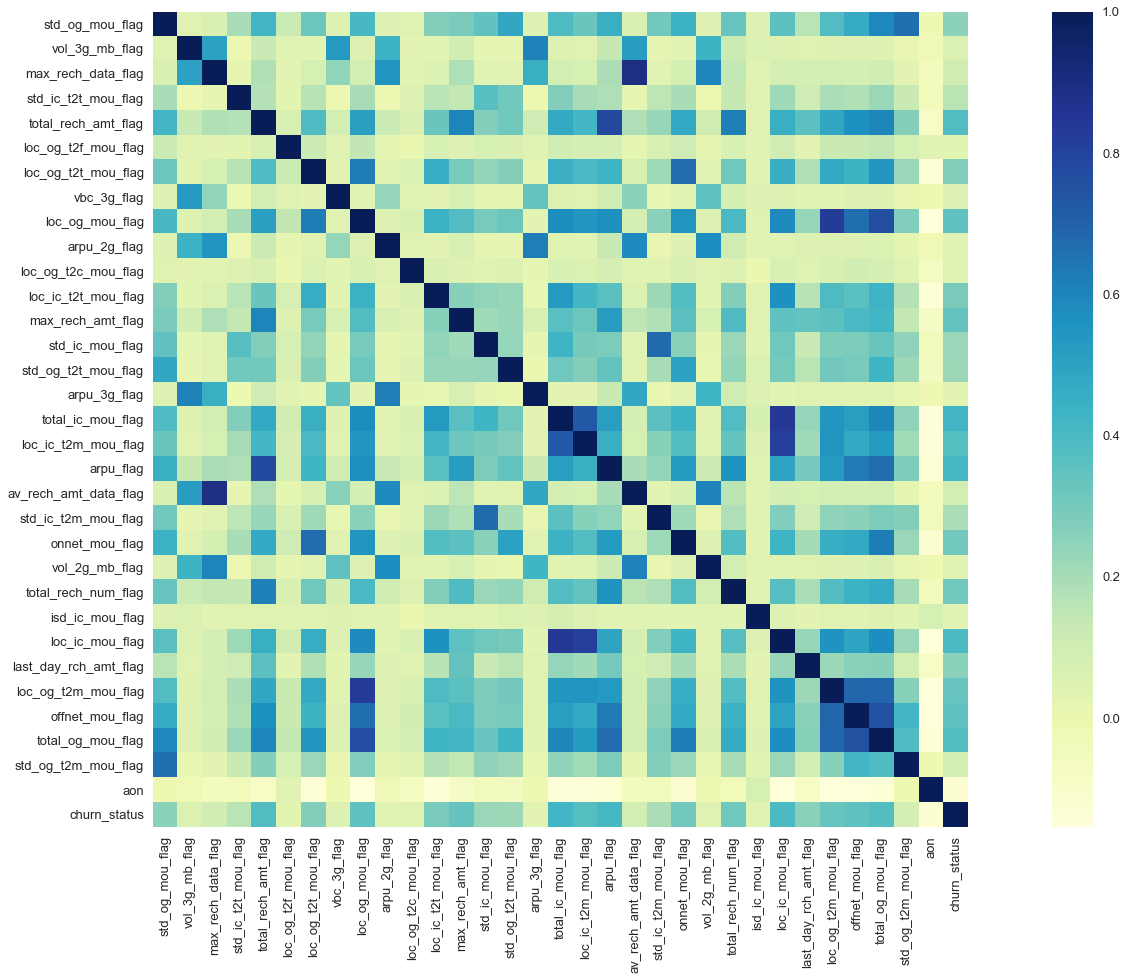

In [34]:
cor_plot(Modeling_Data)

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
#import xgboost as xgb

## Perform Logistic Regression

Model Score :  93.41
Acc_Score :  0.930175672671
Log: [ 0.93362241  0.93512342  0.92895264  0.93195464  0.93194329]
Log: 0.932319277628


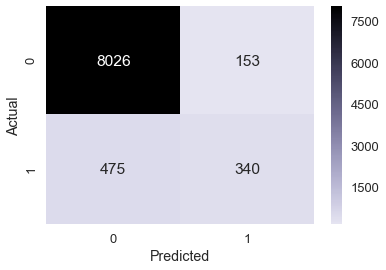

In [83]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
logreg_pred = logreg.predict(X_test)

Model_log = round(logreg.score(X_train,y_train)*100,2)
print("Model Score : " ,Model_log)
Acc_log = accuracy_score(logreg_pred,y_test)
print("Acc_Score : ", Acc_log)


cnf_metrix = (metrics.confusion_matrix(y_test,logreg_pred))
cmap = sns.cubehelix_palette(50, hue=0.5, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cnf_metrix,cmap = cmap,xticklabels=['0','1'],yticklabels=['0','1'],annot=True, fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')


scores = cross_val_score(logreg, X, Y, cv=5, scoring='accuracy') #fitting logistic regression to whole data with 5 fold
print("Log:",scores)
print("Log:" ,scores.mean())

## Perform Decision Tree

Model Score :  92.95
Acc_Score :  0.927062486102
Log: [ 0.93162108  0.92811875  0.92928619  0.92861908  0.92894078]
Log: 0.929317176144


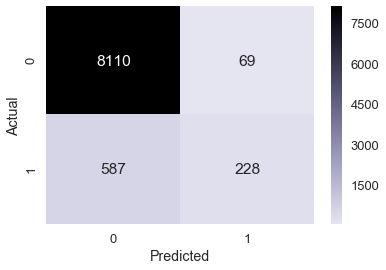

In [89]:

tree = tree.DecisionTreeClassifier(criterion="entropy",max_depth=4)

tree.fit(X_train,y_train)
tree_Pred = tree.predict(X_test).astype(int)



Model_tree = round(tree.score(X_train,y_train)*100,2)
print("Model Score : " ,Model_tree)
Acc_tree = accuracy_score(tree_Pred,y_test,normalize=True)
print("Acc_Score : ", Acc_tree)

#Confusion Metrix 

cnf_metrix = (metrics.confusion_matrix(y_test,tree_Pred))
cmap = sns.cubehelix_palette(50, hue=0.5, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cnf_metrix,cmap = cmap,xticklabels=['0','1'],yticklabels=['0','1'],annot=True, fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Cross-Validation
scores = cross_val_score(tree, X, Y, cv=5, scoring='accuracy') #fitting Decision Tree to whole data with 5 fold
print("Log:",scores)
print("Log:" ,scores.mean())

## Random Forest Tree


Model Score :  93.02
Acc_Score :  0.928063153213
Log: [ 0.93112075  0.92628419  0.9254503   0.92561708  0.92994162]
Log: 0.927682786578


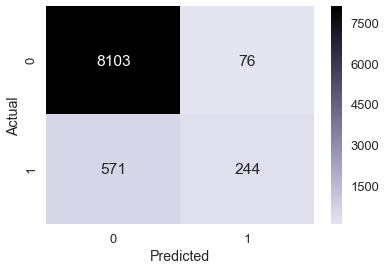

In [77]:
forest = RandomForestClassifier(max_depth = 3, min_samples_split=2, n_estimators = 200, random_state = 1)

forest.fit(X_train,y_train)
forest_Pred = forest.predict(X_test).astype(int)

Model_forest = round(forest.score(X_train,y_train)*100,2)
print("Model Score : " ,Model_forest)
Acc_forest = metrics.accuracy_score(forest_Pred,y_test,normalize=True)
print("Acc_Score : ", Acc_forest)

#Confusion Metrix 

from sklearn import metrics
cnf_metrix = (metrics.confusion_matrix(y_test,forest_Pred))
cmap = sns.cubehelix_palette(50, hue=0.5, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cnf_metrix,cmap = cmap,xticklabels=['0','1'],yticklabels=['0','1'],annot=True, fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')


# Cross-Validation
scores = cross_val_score(forest, X, Y, cv=5, scoring='accuracy') #fitting Decision Tree to whole data with 5 fold
print("Log:",scores)
print("Log:" ,scores.mean())

## Cross Validation function to tune parameters

In [39]:
def Crossvalparam(classifier_name, parameter_name, train_scores, test_scores, param_range = np.logspace(-3, 3, 10)):
    plt.figure()

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title('Validation Curve with ' + classifier_name)
    plt.xlabel('Parameter ' + parameter_name)
    plt.ylabel('Score')
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.semilogx(param_range, train_scores_mean, label='Training score',
                color='darkorange', lw=lw)

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color='darkorange', lw=lw)

    plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
                color='navy', lw=lw)

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color='navy', lw=lw)

    plt.legend(loc='best')
    plt.show()

In [52]:
def modelselectionplot(classifier_name, classifier, parameter_name , param_range = np.logspace(-3, 3, 10)):
    #param_range = np.logspace(-3, 3, 10)
    train_scores, test_scores = validation_curve(classifier, X_train, y_train,
                                                param_name=parameter_name,
                                                param_range=param_range, cv=5)
    Crossvalparam(classifier_name, parameter_name, train_scores, test_scores)

## Use Logistic Regression Classifier :

Accuracy of LogisticRegression classifier on training set: 0.93
Accuracy of LogisticRegression classifier on test set: 0.93


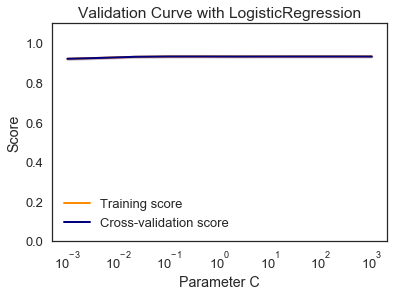

In [78]:


print('Accuracy of LogisticRegression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of LogisticRegression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
modelselectionplot('LogisticRegression', LogisticRegression(),'C')

## Use DecisionTree Classifier :

Accuracy of DecisionTree classifier on training set: 0.92
Accuracy of DecisionTree classifier on test set: 0.92


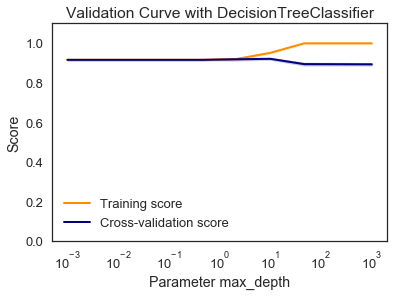

In [79]:


print('Accuracy of DecisionTree classifier on training set: {:.2f}'
     .format(tree.score(X_train, y_train)))
print('Accuracy of DecisionTree classifier on test set: {:.2f}'
     .format(tree.score(X_test, y_test)))
modelselectionplot('DecisionTreeClassifier', DecisionTreeClassifier(),'max_depth')

## Use RandomForest Classifier :

Accuracy of Randomforest classifier on training set: 0.93
Accuracy of Randomforest classifier on test set: 0.93


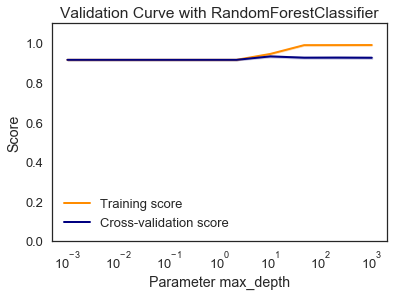

In [59]:

print('Accuracy of Randomforest classifier on training set: {:.2f}'
     .format(forest.score(X_train, y_train)))
print('Accuracy of Randomforest classifier on test set: {:.2f}'
     .format(forest.score(X_test, y_test)))
modelselectionplot('RandomForestClassifier', RandomForestClassifier(),'max_depth')